<a href="https://colab.research.google.com/github/TakahiroDoi/robolympics/blob/main/Copy2_of_robolympics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMA Robolympics: Controlling robots using reinforcement learning

**By Neuromatch Academy**

__Content creators:__ Roman Vaxenburg, Diptodip Deb, Srinivas Turaga

__Production editors:__ Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective

This notebook provides a minimal but complete example of the reinforcement learning infrastructure, training sequence, and result visualization. We will use a [pybullet](https://github.com/bulletphysics/bullet3) locomotion environment and [dm-acme](https://github.com/deepmind/acme) reinforcement learning agents to learn a policy to perform a simple task with the 2D `Hopper` robot. 

We will show how to create and inspect the environment and how to start modifying it to have robots perform various tasks. This example should provide a good starting point for your own exploration!

Even though this example uses a very simple robot, you can start experimenting with more complicated ones, such as `Ant` and `Humanoid` by just importing and modifying them as shown in this example. Also, start exploring the source code of the environments so you can modify them more easily later.

We would also suggest going over the `dm-acme` tutorial notebook:

https://github.com/deepmind/acme/blob/master/examples/tutorial.ipynb

For a general introduction to Reinforcement Learning, it's worth checking out this course:

https://deepmind.com/learning-resources/-introduction-reinforcement-learning-david-silver


# Colab limits

Please note that due to the Colab usage limits on the one hand, and the compute requirements of the project on the other hand, most likely you won't be able to leverage Colab's GPU for a sufficient amount of time. Instead, we suggest working in CPU-only mode (it shouldn't slow you down very much, typical RL workloads are CPU-bound anyway). Make sure you're not using GPU by doing Runtime -> Change runtime type -> Hardware accelerator -> None.

Also, when instantiating the environments, make sure to keep the default setting `render=False`.

---
# Setup

# TODO
* [X] Plot distance explicitely
* [X] Save the video to google drive  
* [ ] Cumulative average rewrad over steps [start, current] in each episode to assess convergence    
* [ ] Mechanism to save model environment and experiment results  
* [ ] See if I can dynamically change the target distance inside the step function 
  * Why wouldn't I??
* [X] Output current x location of the hopper (during the trainig, during testing)
  * Right now using 'foot' (not sure which part is used in self.calc_potential)
* [X] Make our own calc_potential() that uses avg_body_x to eliminate the bias 
  * This did not work! So maybe the bias arises from the innate step size of the current Hopper 

## General
* [X] Early stoppming mechanism to pick the best model out of the whole training
  * It is inside environment_loop.py so perhpas too deep to touch.
  * It is possible to implement early stopping by creating a larger custom loop that encapsulate the original loop       
* [X] Made sure the checkpoint worked
  * Added agent_name to check point (reflectged on the subdir name) 
* [X] tensorflow update introduced dependency issue, so added explicit version requirements to all software packages  

## 100m dash 
* [X] Add velocity to the list of rewards  
* [X] Increase the velocity contribution
  * Not helping    
* [ ] Metric to measure the success (time/steps taken to reach the goal?)   

### Getting a solid walker 
* [X] 2021-08-13. Some of us experienced that 200_000 steps are not enough for getting the hopper walking (perhaps because of installing different version(s) of package(s)?
* [X] 300_000 step training did it [hopper_walker2]  
* [X] Giving additional 300_000 million step training [hopper_walker3]
* [X] hopper_walker 3 vs 2. they walk slighly differently. let's see which walks faster.
  * walker3 is faster (presumably due to more training)

## Walk and stop
* hopper_walker3 falls after reaching its destination (more like overshoot a little and pulled back in the next step and fall) 
* Let's train walker3 to be able to stand still after reaching the destination 
  * distance 10
  * after 100_000 step training: it cannot walk 10m anymore... it falls before reaching 10m 
  * after another 1_000_000 step training: it reaches the goal more often but the episode ends there... does an episode end when the hopper reaches the destination? No indication of that in environment_loop.py, but we can doulbe check that by training a hopper with the target distance zero.
    * [X] Episode does not terminate based on the location and distance (see below) 
    * [X] Nothing indicates so in _isDone() method either  

## Zero distance 
* Start from a brand new hopper 
* with ~2_000 step training, it learned to stand still. So episode does NOT terminate based on the location   

## Back walk 
* Start from a brand new hopper 
* target location (-1000, 0) 
* 300_000 step training was enough
* But of course this guy cannot hope forward if the goal is set to (1000,0)  

## Arbitrary distance  
### Positive and zero distance  
* See if the current agent type and architecture can handle it  
* Give x = 1000 and 0 randomly during the training?     
1. [Rejected] Perhaps, we should just include target x in the "state" explicitly?      
  * Not sure which scripts to modify to achieve this
  * Is this more like a "supervised learning?"
    * So perhaps, tweeking the reward function in step() is better

2. [Success] Just training the hopper with two target distances (0, 1000)
  * No modificiation of reward function 
  * Went well with increased alive coef: 1 -> 2. switch during training

# Notes
* Max steps seem 1000 per episode 
* Potential seems -60 * distance

# Hopper
* walker2: wakling after default training (~350,000 step)     
* walker3: Additional ~350,000 step training to walker2 (w/ defualt settings). Seems walker3 walks faster than walker2, but is more prone to falling. 
* walkandstop1: unsuccessful after million step training (on top of  hopper_walker3)      
* zerodistance: trained on zero distance. successful training 
* backhopper: trained on zero distance. successful training 
* two_goal_: trained on zero distance. successful training 

# Possible project questions 
* Hopper that can stop and stay head up
* Hopper that can handle an arbitrary (static) goal (negative, zero, positive x) 
* Hopper that can handle a dynamic goal

In [31]:
b_install = True
# b_install = False

In [32]:
if b_install:
  from IPython.display import clear_output
  !sudo apt-get -q install ffmpeg freeglut3-dev xvfb  # For visualization.

  !pip install tensorflow==2.6.0 --quiet
  !pip install dm-sonnet==2.0.0 --quiet
  !pip install imageio-ffmpeg --quiet
  !pip install pybullet==3.1.7 --quiet
  !pip install dm-acme[tf]==0.2.0 dm-acme[reverb]==0.2.0 --quiet

  clear_output()

In [33]:
# Shuqi
# The dependencies are downloaded into our shared google drive: under local_python_dependencies. And the blocks to use that would be: 

# 1) mount your google drive:
# import os, sys
# from google.colab import drive
# drive.mount('/content/drive')

# Then establish a link:
# content/drive/MyDrive/: My google drive
# nb_path = '/content/python_dependencies'
# os.symlink('/content/drive/MyDrive/Jockeys-NMA/local_python_dependencies', nb_path)
# sys.path.insert(0,nb_path)

# Then you should be able to skipp the pip install block and go ahead and run the import block.
# So for google drive to recognize your shared drive, we also need to go to the shared drive folder itself and then right click to add [the shortcut] to my drive. 
# Otherwise colab wouldn't be able to find it

In [34]:
# Imports
import os
import shutil
import matplotlib

# Hopper and environment (open source implementaiton of OpenAI Gym)
import pybullet_envs

# RL algorithem  
from acme.utils import loggers
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.agents.tf.d4pg import D4PG
from acme.agents.tf.ddpg import DDPG
from acme.agents.tf.dmpo import DistributionalMPO
from acme import wrappers, specs, environment_loop

import numpy as np
import sonnet as snt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from google.colab import drive
from IPython.display import HTML

In [35]:
from IPython.core.debugger import set_trace

In [36]:
# @title Import `pybullet` locomotion environments

from pybullet_envs.gym_locomotion_envs import HopperBulletEnv
from pybullet_envs.gym_locomotion_envs import Walker2DBulletEnv
from pybullet_envs.gym_locomotion_envs import HalfCheetahBulletEnv
from pybullet_envs.gym_locomotion_envs import AntBulletEnv
from pybullet_envs.gym_locomotion_envs import HumanoidBulletEnv

In [37]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [38]:
b_skip_cell = True

---
# Functions for saving and restoring checkpoints
Due to Colab usage limits, the Colab runtime will be restarting periodically. In order to preserve the most recent training checkpoint during a restart, please use the functions below.

To do so, you'll have to first mount Google Drive (will be shown below).

### Before runtime restart:
Use `save_ckpt_to_drive` to locate the checkpoint and save it to your Google Drive in a directory `/acme_ckpt`

### After runtime restart:
Use `restore_ckpt_from_drive` to recover the checkpoint from Google Drive and copy it back to the restarted Colab virtual machine.

In [39]:
def save_ckpt_to_drive(agent, agent_name):
  """Saves agent checkpoint directory to Google Drive.

  WARNING: Will replace the entire content of the
  drive directory `/root/drive/MyDrive/acme_ckpt`.

  Args:
    agent: core.Actor

  /root/drive/MyDrive
  My google drive 
  """
  src = agent._learner._checkpointer._checkpoint_manager.directory
  dst = '/root/drive/MyDrive/acme_ckpt/' + agent_name
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Saved {src} to {dst}')


def restore_ckpt_from_drive(agent, agent_name):
  """Restores agent checkpoint directory from Google Drive.

  The name of the local checkpoint directory will be different
  than it was when the checkpoint was originally saved.
  This is because `acme` checkpoiner creates a new directory
  upon restart.

  WARNING: Will replace the entire content of the local
  checkpoint directory (if it exists already).

  Args:
    agent: core.Actor
  """
  src = '/root/drive/MyDrive/acme_ckpt/'+ agent_name
  dst = agent._learner._checkpointer._checkpoint_manager.directory
  if os.path.exists(dst):
        shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Restored {dst} from {src}')

---
# Convenience function for creating videos

Use this function to generate videos of your experiments.

In [40]:
def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

---
# Network factory methods for select continuous control agents
The functions below initialize and return the policy and critic networks for several continuous control agents (DDPG, D4PG, DMPO) used later in this notebook. Feel free to explore other agents as well. For more information on these and other agents, their implementations, and links to their corresponding papers see
https://github.com/deepmind/acme/tree/master/acme/agents

Please note that the hyperparameters `layer_sizes`, `vmin`, `vmax`, `num_atoms` are set to reasonable default values, but may reqiure adjustment. Especially, `vmin` and `vmax` should be used with care. Please see, e.g., https://github.com/deepmind/acme/blob/master/acme/agents/tf/d4pg/README.md for more information.

In [41]:
def make_networks_d4pg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for D4PG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = snt.Sequential([
      networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes,
              activate_final=True),
      ),
      networks.DiscreteValuedHead(vmin=vmin,
                                  vmax=vmax,
                                  num_atoms=num_atoms)
      ])

  return policy_network, critic_network


def make_networks_ddpg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                      ):
  """Networks for DDPG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes + (1,),
              activate_final=False),
              )

  return policy_network, critic_network


def make_networks_dmpo(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for DMPO agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes,
                            activate_final=True),
      networks.MultivariateNormalDiagHead(
          action_size,
          min_scale=1e-6,
          tanh_mean=False,
          init_scale=0.7,
          fixed_scale=False,
          use_tfd_independent=True)
  ])

  # The multiplexer concatenates the (maybe transformed) observations/actions.
  critic_network = networks.CriticMultiplexer(
      action_network=networks.ClipToSpec(action_spec),
      critic_network=networks.LayerNormMLP(layer_sizes=critic_layer_sizes,
                                           activate_final=True),
                                           )
  critic_network = snt.Sequential([
                                   critic_network,
                                   networks.DiscreteValuedHead(vmin=vmin,
                                                               vmax=vmax,
                                                               num_atoms=num_atoms)
                                   ])

  return policy_network, critic_network

---
# List of all `pybullet` environments

You can print the full list of environments by running the cell below. Only a subset of them are locomotion environments but feel free to explore the other ones if you're interested.

In [42]:
pybullet_envs.getList()

['- HumanoidDeepMimicBackflipBulletEnv-v1',
 '- HumanoidDeepMimicWalkBulletEnv-v1',
 '- CartPoleBulletEnv-v1',
 '- CartPoleContinuousBulletEnv-v0',
 '- MinitaurBulletEnv-v0',
 '- MinitaurBulletDuckEnv-v0',
 '- RacecarBulletEnv-v0',
 '- RacecarZedBulletEnv-v0',
 '- KukaBulletEnv-v0',
 '- KukaCamBulletEnv-v0',
 '- InvertedPendulumBulletEnv-v0',
 '- InvertedDoublePendulumBulletEnv-v0',
 '- InvertedPendulumSwingupBulletEnv-v0',
 '- ReacherBulletEnv-v0',
 '- PusherBulletEnv-v0',
 '- ThrowerBulletEnv-v0',
 '- Walker2DBulletEnv-v0',
 '- HalfCheetahBulletEnv-v0',
 '- AntBulletEnv-v0',
 '- HopperBulletEnv-v0',
 '- HumanoidBulletEnv-v0',
 '- HumanoidFlagrunBulletEnv-v0',
 '- HumanoidFlagrunHarderBulletEnv-v0',
 '- MinitaurExtendedEnv-v0',
 '- MinitaurReactiveEnv-v0',
 '- MinitaurBallGymEnv-v0',
 '- MinitaurTrottingEnv-v0',
 '- MinitaurStandGymEnv-v0',
 '- MinitaurAlternatingLegsEnv-v0',
 '- MinitaurFourLegStandEnv-v0',
 '- KukaDiverseObjectGrasping-v0']

---
# Modifying the environment base class

You may start your exploration of the `pybullet` locomotion environment code from this entry point, going up and down the hierarchy of classes:

https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/gym_locomotion_envs.py

For our experiments, we will be using the `pybullet` locomotion environments with several different robots (`Hopper`, `Ant`, `Humanoid`, etc.). In order to have the robots perform different tasks, we'll need to modify some parts of the environments' code. This will (mainly) amount to modifying the environments' reward calculation in the `step` method.

In the cell below we provide a minimal example modifying the `HopperBulletEnv` environment class. Normally, to create a Hopper environment you would just create an instance of the HopperBulletEnv class:

```
env = HopperBulletEnv()
```
However, if you analyze the environment's code, you'll realize that making changes (such as modifying the reward calculation) is difficult in this way. Instead, it's useful to create a custom child class inheriting from the original `HopperBulletEnv` class and override some of its methods. This subclassing will allow you to easily access the interesting pieces of the environment class to modify.

In the example of a custom `Hopper` class below, we override several methods of its parent class to (i) make the reward calculation modifiable, (ii) add `step_counter` to enforce fixed episode duration, and (iii) make the episode termination conditions modifiable. Please note that in some cases the overriding methods still call their parent methods after executing the required modifications (such as the `__init__`, `reset`, `_isDone` methods do.). In contrast, the `step` method is overriden in its entirety and doesn't reference its parent method. So instead of the code line above, the environment would be created as:
```python
env = Hopper()
```
You can use this approach and this example as the starting point of your project. In many cases, this custom class can be used as is (with only a name change) with other robots in the `pybullet` locomotion environments by inheriting from their respective original environment classes instead of from `HopperBulletEnv`.

In [43]:
# Global variable used inside Hopper()
# Not ideal, but keeping them as global vars because I am not exactly sure how 
# checkpoint works. 

# speed_coef        = 1
# speed_coef        = 100
# speed_coef        = 0.1
speed_coef          = 0 # Original rew

# alive_coef          = 3    # Used for: hopper_two_goal_training2, hopper_walker4
alive_coef          = 1

electricity_coef    = 1
feet_collision_coef = 1
progress_coef       = 1

# Target dynamics 
# idx_target_dynamic = 0  # Static, do nothing, defualt
idx_target_dynamic = 1    # Increment walk_target_x after a 100-step stable standing from Hopper reaching the target   

In [44]:
# Set to True to show what's happening whe an episode ends.  
show_params_at_DONE = False

In [45]:
# Compute average boday parts x location
# Used to assess where it is 
def compute_average_body_x(env):
    tmp1 = env.robot.parts['foot'].pose().xyz()[0]
    tmp2 = env.robot.parts['leg'].pose().xyz()[0]
    tmp3 = env.robot.parts['thigh'].pose().xyz()[0]
    tmp4 = env.robot.parts['torso'].pose().xyz()[0]
    body_x_avg = (tmp1+tmp2+tmp3+tmp4)*0.25
    return body_x_avg

In [162]:
# use this instead of built in calc_potential to eliminate a bias in avg_body_x when Hopper reaches walk_target_x
# consider only x   
def custom_calc_potential_x(env): 
  avg_body_x = compute_average_body_x(env)
  # coefficient must have been something around 60 (in the original calc_potential)
  coef = 60
  potential  = -coef*abs(avg_body_x-env.walk_target_x)
  return potential

In [172]:
# Change in class def will be reflected if you do runtime reset 
# even if you are loading checkpoint 

#from importlib import reload
#reload(Hopper) # This does not work because Hopper is not a module 

class Hopper(HopperBulletEnv):

  def __init__(self, render=False, episode_steps=1000):
    """Modifies `__init__` in `HopperBulletEnv` parent class."""

    # Default num of steps per episode is 1000
    self.episode_steps = episode_steps
     
    # Is going to be used for changing target_x
    buffer_size = 100 # baesd on the slow hopper (hopper_two_goal_training3)
    self.avg_body_x_buffer = np.zeros(buffer_size)
    
    super().__init__(render=render)

  def reset(self):
    """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
    self.step_counter = 0
    self.step_counter_at_target_update = []
    return super().reset()

  def _isDone(self):
    """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
    # Maybe I should check super()_isDone()
    # it's just returns True for is_alive < 0
    # https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/gym_locomotion_envs.py
    # Termination condition beyond what's in environment_loop.py 

    return (self.step_counter == self.episode_steps
            or super()._isDone())

  def step(self, a):
    """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

    # a: three elements in the range of [-1, 1], each corresponding to a joint actuator 

    self.step_counter += 1

    # if multiplayer, action first applied to all robots,
    # then global step() called, then _step() for all robots
    # with the same actions
    if not self.scene.multiplayer:
      self.robot.apply_action(a)
      self.scene.global_step()

    state = self.robot.calc_state()  # also calculates self.joints_at_limit

    # state[0] is body height above ground, body_rpy[1] is pitch
    self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z, self.robot.body_rpy[1]))
    done = self._isDone()
    if not np.isfinite(state).all():
      print("~INF~", state)
      done = True

    potential_old  = self.potential
    self.potential = self.robot.calc_potential()     # -100 of norm of the distance-to-target  
                                                     # https://github.com/bulletphysics/bullet3/blob/0e124cb2f103c40de4afac6c100b7e8e1f5d9e15/examples/pybullet/gym/pybullet_envs/gym_manipulator_envs.py#L96
                                                     # I suspect the coefficient is something more like -60 from the comparison of potential and avg_body_x 
    # self.potential = custom_calc_potential_x(self)     # To eliminate a bias, this did NOT work... 
    progress = float(self.potential - potential_old) # progress is difference between remaining distances so it's like velocity   

    # Taka: printout the potential when done  
    if (done) & (show_params_at_DONE):
      print('********* DONE *********')
      print('potential: ',     self.potential)
      print('walk_target_x: ', self.robot.walk_target_x)
      print('foot x:',         self.robot.parts['foot'].pose().xyz()[0])
      print('initial_z: ',     self.robot.initial_z)
      print('state[0] (body height above ground): ', state[0])
      print('body_rpy[1] (pitch): ',                 self.robot.body_rpy[1])

    # For 100m dash  
    robot_speed   = self.robot_body.speed()
    robot_speed_x = robot_speed[0]
 
    # ideas 
    # - speed coef * 1000
    # - how to calculate a scalar value from the speed vector 

    feet_collision_cost = 0.0
    for i, f in enumerate(self.robot.feet):
      contact_ids = set((x[2], x[4]) for x in f.contact_list())
      if (self.ground_ids & contact_ids):
        self.robot.feet_contact[i] = 1.0
      else:
        self.robot.feet_contact[i] = 0.0

    # let's assume we have DC motor with controller, and reverse current braking
    electricity_cost = self.electricity_cost * float(
        np.abs(a * self.robot.joint_speeds).mean())
    electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

    joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)
    
    # if alive_coef is not 1:
    #   print('alive_coef: ', alive_coef) 
    # print('alive_coef: ', alive_coef) 

    # Modified for different goals 
    self.rewards = [
                    alive_coef*self._alive, progress_coef*progress, electricity_coef*electricity_cost,
                    joints_at_limit_cost, feet_collision_coef*feet_collision_cost, 
                    speed_coef * robot_speed_x
                   ]

    self.HUD(state, a, done)
    self.reward += sum(self.rewards)

    # Dynamic target
    # Store avg_body_x
    avg_body_x = compute_average_body_x(env)
    self.avg_body_x_buffer = np.append(self.avg_body_x_buffer, avg_body_x)
    self.avg_body_x_buffer = self.avg_body_x_buffer[1:]
    
    if idx_target_dynamic==1:
      # These parameter values were chosen based on hopper_two_goal_training3
      avg_body_x_condition = {'mean_overshoot':0.05, 'half_width_range':0.07}
      # half_width_range: 0.05 initial 
      # half_width_range: 0.07 (2021-08-18, 0.05 was too tight. sometimes Hopper didn't re-move forward)
      baseline =  self.robot.walk_target_x + avg_body_x_condition['mean_overshoot']
      lo_criterion = baseline - avg_body_x_condition['half_width_range']
      up_criterion = baseline + avg_body_x_condition['half_width_range']
      meet_criterion = ((self.avg_body_x_buffer > lo_criterion) & (self.avg_body_x_buffer < up_criterion)).all() 
      
      if meet_criterion:
        self.robot.walk_target_x += self.robot.walk_target_x
        print('walk_target_x is updated: ', self.robot.walk_target_x)
        print('current step_counter: ', self.step_counter)
        self.step_counter_at_target_update.append(self.step_counter) # NOTE that list.append() returns None  

    return state, sum(self.rewards), bool(done), {}

In [47]:
#i mport numpy as np
# aaa = np.random.rand(10)
# bbb = ((aaa>0.3) & (aaa<0.7)).all()
# print(bbb)

---
# Instantiate the environment

Here, we are creating an example `Hopper` environment. Once created, we are wrapping it with `GymWrapper` to make the native `Gym` environment interface compatible with the one used in the `dm-acme` library, which is the reinforcement package that we will be using. `dm-acme` adheres to the interface defined here: https://github.com/deepmind/dm_env. Finally, we also use `SinglePrecisionWrapper` to enforce single-precision on a potentially double-precision environment.


In [173]:
# you can change max num of steps per episode by specifying it in the input args 
max_episode_steps = 1000
env = Hopper(render=False, episode_steps = max_episode_steps)

env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)

action_spec = env.action_spec()  # Specifies action shape and dimensions.
env_spec = specs.make_environment_spec(env)  # Environment specifications.

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---
# The default task

If not modified, the default task of the `HopperBulletEnv` environment is to have the robot hop to the target location located 1 km away. The target location is stored as an attribute of the `robot` object and can be accessed as in the cell below.

The task also contains other constraints, such as `electricity_cost`, and certain episode termination conditions. Please start from our custom `Hopper` class in the above cell and work your way backwards to the the environment code for more details!

In [49]:
# x and y coordinates of the target location.

idx_task_type = 0  # Default 
# idx_task_type = 1  # 100m dash
# idx_task_type = 2  # high jump 
# idx_task_type = 3  # walk and stop
# idx_task_type = 4  # zero  
# idx_task_type = 5  # Backwalk  
# idx_task_type = -1   # Do nothing

if idx_task_type == 0:
  ## default  
  env.robot.walk_target_x = 1000
  env.robot.walk_target_y = 0

elif idx_task_type == 1:
  ## 100m dash 
  env.robot.walk_target_x = 100
  env.robot.walk_target_y = 0

elif idx_task_type == 2:
  ## Jump 
  env.robot.walk_target_x = 0
  env.robot.walk_target_y = 10

elif idx_task_type == 3:
  ## walk and stop 
  env.robot.walk_target_x = 10
  env.robot.walk_target_y = 0

elif idx_task_type == 4:
  ## walk and stop 
  env.robot.walk_target_x = 0
  env.robot.walk_target_y = 0

elif idx_task_type == 5:
  ## walk and stop 
  env.robot.walk_target_x = -1000
  env.robot.walk_target_y = 0

elif idx_task_type == -1:
  print('do nothing') 

env.walk_target_x_ini = env.robot.walk_target_x

print('Current target distination')
env.robot.walk_target_x, env.robot.walk_target_y

Current target distination


(1000, 0)

In [50]:
speed_coef

0

---
# Let's inspect the environment a bit

#### Plot one frame of the environment

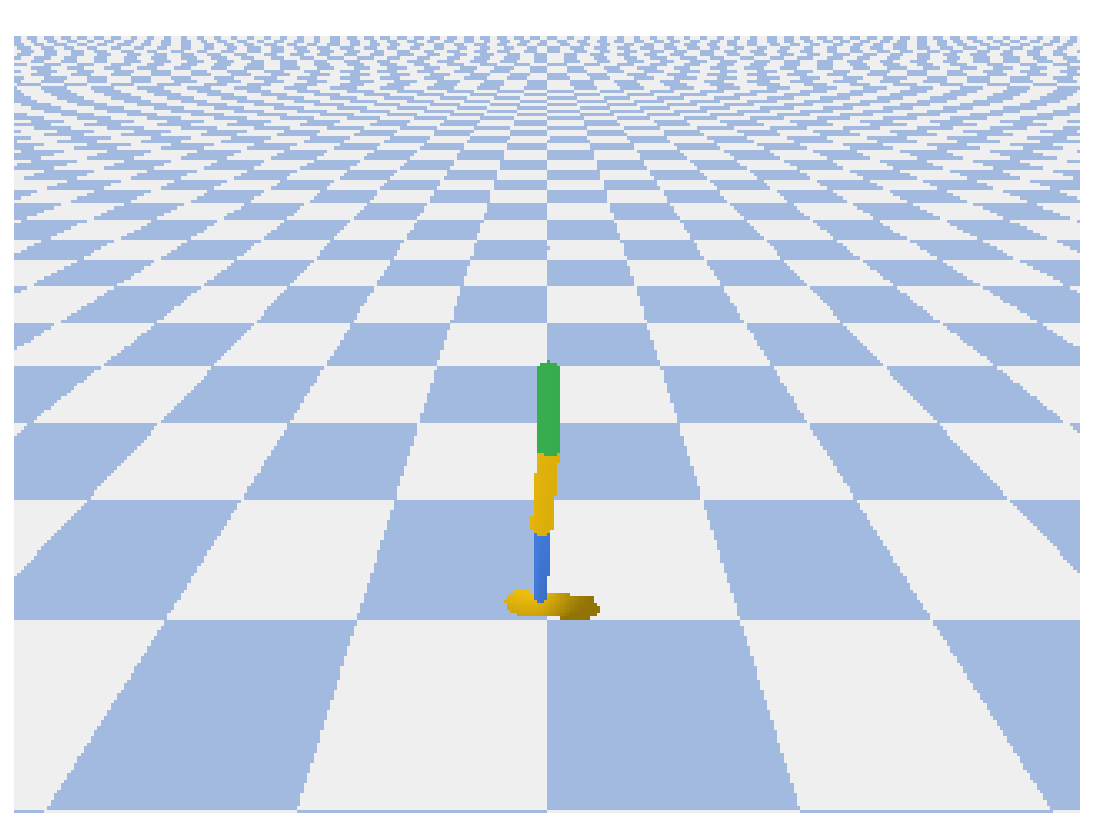

In [51]:
_ = env.reset()

frame = env.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

## Run the environment with random actions

We haven't trained the policy yet, but we can still see the environment in action by passing a random control sequence to it.

In [52]:
if not b_skip_cell:
  # Run env for n_steps, apply random actions, and show video.
  n_steps = 200

  frames = []
  timestep = env.reset()
  for _ in range(n_steps):
    # Random control of actuators.
    action = np.random.uniform(action_spec.minimum,
                              action_spec.maximum,
                              size=action_spec.shape)
    timestep = env.step(action)
    frames.append(env.environment.render(mode='rgb_array'))

  display_video(frames, framerate=20)

## Lets take a look at some other environment properties

Notice the shapes and min/max limits

In [53]:
if not b_skip_cell:
  # Actions: three joints' actuators 
  print('Actions:\n', env_spec.actions)
  print('Observations:\n', env_spec.observations)
  print('Rewards:\n', env_spec.rewards)

## Inspect some of the robot properties

Let's examine the (Cartesian) coordinates of different body parts of the robot and its speed. Notice that `robot` is an attribute of the `env` class. Also, note how the body parts are accessed as you may need it for adjusting the reward calculation in your project. 

Feel free to explore other properties (attributes) of the `env.robot` object, such as velocities, joint angles, etc.

In [54]:
b_skip_cell = False
if not b_skip_cell:
  # Cartesian coordinates of body parts.
  for body_part in env.robot.parts.keys():
    print(f"{body_part:10} {env.robot.parts[body_part].pose().xyz()}")

link0_2    [0. 0. 0.]
torso      [0.   0.   1.25]
link0_3    [0. 0. 0.]
link0_4    [0. 0. 0.]
link0_6    [-8.67361738e-19  0.00000000e+00  1.04999995e+00]
thigh      [-0.01679107  0.          0.8256274 ]
link0_8    [-0.03358214  0.          0.60125484]
leg        [-0.03939873  0.          0.3513225 ]
link0_10   [-0.04521531  0.          0.10139017]
foot       [0.01936337 0.         0.09400144]
floor      [0. 0. 0.]


In [55]:
# Cartesian components of robot speed.
# Now it seems the dimension is [forward/backward, sideways, up/down]
env.robot_body.speed()

array([0., 0., 0.])

---
# Create the `dm-acme` agent

Now we are ready to create the agent. Below we provide examples of creating instances of three select agents (DDPG, D4PG, DMPO) that we implemented above. Please feel free to explore other agents as well. For more information on these and other agents, their implementations, and links to their corresponding papers see
https://github.com/deepmind/acme/tree/master/acme/agents

The direct links to the implementation of these three agents for you to start exploring are:

https://github.com/deepmind/acme/blob/master/acme/agents/tf/ddpg/agent.py

https://github.com/deepmind/acme/blob/master/acme/agents/tf/d4pg/agent.py

https://github.com/deepmind/acme/blob/master/acme/agents/tf/dmpo/agent.py


First, lets configure loggers and optimizers:

In [56]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every    = 60.  # Environment loop logging frequency, seconds.
checkpoint = True  # Checkpoint saved every 10 minutes.

learner_logger = loggers.TerminalLogger(label='Learner',
                                        time_delta=learner_log_every,
                                        print_fn=print)
loop_logger = loggers.TerminalLogger(label='Environment Loop',
                                     time_delta=loop_log_every,
                                     print_fn=print)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.

# lr = 1e-3
lr = 1e-4 #Default
# lr = 1e-5 
policy_optimizer = snt.optimizers.Adam(lr)
critic_optimizer = snt.optimizers.Adam(lr)

---
# D4PG agent

As an example, in the next cell we instantiate the D4PG agent. Examples of other agents (DDPG, DMPO) are provided at the end of the notebook.

In [57]:
b_agent_D4PG = True
b_agent_DDPG = False

In [58]:
# checkpoint = False  # start fresh 
checkpoint = True
if b_agent_D4PG:
  # Create networks.
  policy_network, critic_network = make_networks_d4pg(action_spec)

  # Create agent.
  agent = D4PG(environment_spec=env_spec,
               policy_network=policy_network,
               critic_network=critic_network,
               observation_network=tf2_utils.batch_concat, # Identity Op.
               policy_optimizer=policy_optimizer,
               critic_optimizer=critic_optimizer,
               logger=learner_logger,
               checkpoint=checkpoint)

In [59]:
# dir(agent)

In [60]:
assert checkpoint is True, 'check point must be set True'

In [61]:
if b_agent_DDPG:

  # Create networks.
  policy_network, critic_network = make_networks_ddpg(action_spec)

  # Create agent.
  agent = DDPG(environment_spec=env_spec,
               policy_network=policy_network,
               critic_network=critic_network,
               observation_network= tf2_utils.batch_concat, # Identity Op.
               logger=learner_logger,
               checkpoint=checkpoint)

---
# Training

Finally, we are ready to start training!

Please refer to the source code to see how to use the environment loop:

https://github.com/deepmind/acme/blob/master/acme/environment_loop.py

The training checkpoint (containing the network weights, optimizer parameters, etc.) will be saved every 10 minutes. Please remember to save and then restore the checkpoint from Google Drive if you are restarting the Colab runtime. See example below.

*Note:* `num_steps = 100_000` but we reduce it to 1000 to reduce computational time. Please change it back if you want to see the original output of the model.

In [62]:
# Perhaps, when I run the loop for more than 10 mins, I should have the same dir name for load and save 

# Check point loading from: 
# load_agent_name = 'hopper_walker2'
# load_agent_name = 'hopper_walker3'
# load_agent_name = 'hopper_walkandstop1'
# load_agent_name = 'hopper_zerodistance'
# load_agent_name = 'hopper_backwalker1' # just a long training after walker3. didn't solve
# load_agent_name = 'hopper_two_goal_training1'
# load_agent_name = 'hopper_two_goal_training2'
# load_agent_name = 'hopper_walker4'
load_agent_name = 'hopper_two_goal_training3'

# Used for saving checkpoint too 
## save_agent_name = 'hopper_walker2' # Don't choose this anymore. Freeze it.     
# save_agent_name = 'hopper_walker3'    # Train hopper_walker2 with more steps 
## save_agent_name = 'hopper_100mdash'
# save_agent_name = 'test2'

# save_agent_name = 'hopper_walkandstop1'
# save_agent_name = 'hopper_zerodistance'
# save_agent_name = 'hopper_backwalker1'
# save_agent_name = 'hopper_arbitrarytarget'
# save_agent_name = 'hopper_two_goal_training1'
# save_agent_name = 'hopper_two_goal_training2'
# save_agent_name = 'hopper_walker4'
save_agent_name = 'hopper_two_goal_training3'

In [31]:
# idx_training_design = 0  # Default
# idx_training_design = 1  # Alternative walk_target_x 0, 1000
idx_training_design = 2    # Alternative walk_target_x 0, 1000; alive_coef 1 then 2 (last 50 blocks)

if idx_training_design == 0:
  num_blocks    = 1
  num_episodes  = None

  # num_steps  =     1_000 
  # num_steps  =    10_000
  # num_steps  =   100_000
  # num_steps  =   200_000
  num_steps  =   300_000
  # num_steps =    500_000
  # num_steps  = 1_000_000
  print('Default training design')

elif idx_training_design == 1:
  # Training environment 
  # env.robot.walk_target_x
  # alternating between 0 and 1000
  num_blocks    = 100
  num_episodes  = 10
  num_steps     = None 
  list_walk_target_x = np.arange(num_blocks)
  list_walk_target_x[0::2] = 0
  list_walk_target_x[1::2] = 1000

  print('list_walk_target_x for training blocks')
  print(list_walk_target_x)

elif idx_training_design == 2:
  # Training environment 
  # env.robot.walk_target_x
  # alternating between 0 and 1000
  num_blocks    = 150
  num_episodes  = 10
  num_steps     = None 
  list_walk_target_x = np.arange(num_blocks)
  list_walk_target_x[0::2] = 0
  list_walk_target_x[1::2] = 1000

  list_alive_coef = np.arange(num_blocks)
  list_alive_coef[0:100] = 1
  list_alive_coef[100:]  = 2
  
  print('list_walk_target_x for training blocks')
  print(list_walk_target_x)

  print('list_alive_coef for training blocks')
  print(list_alive_coef)

list_walk_target_x for training blocks
[   0 1000    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000
    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000
    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000
    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000
    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000
    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000
    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000
    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000
    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000
    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000    0 1000
    0 1000    0 1000    0 1000    0 1000    0 1000]
list_alive_coef for training blocks
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 

In [32]:
# show_params_at_DONE = True
show_params_at_DONE = False

print('Default')
print('walk_target_x:', env.robot.walk_target_x)
print('walk_target_y:', env.robot.walk_target_y)

input("Press Enter to start Training...\n")




loop = environment_loop.EnvironmentLoop(env, agent, logger=loop_logger)

# Start training!
# Episode loop is inside 
# loop.run(num_episodes=None,
#          num_steps=num_steps)

for idx_block in range(num_blocks): 
  # Seems this is working
  if idx_training_design == 1:
    env.robot.walk_target_x = list_walk_target_x[idx_block]
    print('-- New training block ', idx_block, ' --')
    print('walk_target_x: ', env.robot.walk_target_x)

  elif idx_training_design == 2:
    env.robot.walk_target_x = list_walk_target_x[idx_block]
    alive_coef              = list_alive_coef[idx_block]
    print('-- New training block ', idx_block, ' --')
    print('walk_target_x: ', env.robot.walk_target_x, '  |  alive_coef:',alive_coef)  
  
  # Episode based training
  loop.run(num_episodes=num_episodes,
           num_steps=num_steps)


# perhaps I should use a while loop 
# moving onto the next block only when the total step count exceeds a certain threshold 
# 300 steps/episode * #episodes   


show_params_at_DONE = False

Default
walk_target_x: 1000
walk_target_y: 0
Press Enter to start Training...

-- New training block  0  --
walk_target_x:  0   |  alive_coef: 1
-- New training block  1  --
walk_target_x:  1000   |  alive_coef: 1
-- New training block  2  --
walk_target_x:  0   |  alive_coef: 1
-- New training block  3  --
walk_target_x:  1000   |  alive_coef: 1
-- New training block  4  --
walk_target_x:  0   |  alive_coef: 1


INFO:tensorflow:Assets written to: /root/acme/9c6eae66-ff11-11eb-9917-0242ac1c0002/snapshots/policy/assets


INFO:tensorflow:Assets written to: /root/acme/9c6eae66-ff11-11eb-9917-0242ac1c0002/snapshots/policy/assets


INFO:tensorflow:Assets written to: /root/acme/9c6eae66-ff11-11eb-9917-0242ac1c0002/snapshots/critic/assets


INFO:tensorflow:Assets written to: /root/acme/9c6eae66-ff11-11eb-9917-0242ac1c0002/snapshots/critic/assets


-- New training block  5  --
walk_target_x:  1000   |  alive_coef: 1
-- New training block  6  --
walk_target_x:  0   |  alive_coef: 1
-- New training block  7  --
walk_target_x:  1000   |  alive_coef: 1
-- New training block  8  --
walk_target_x:  0   |  alive_coef: 1
-- New training block  9  --
walk_target_x:  1000   |  alive_coef: 1
-- New training block  10  --
walk_target_x:  0   |  alive_coef: 1
-- New training block  11  --
walk_target_x:  1000   |  alive_coef: 1
-- New training block  12  --
walk_target_x:  0   |  alive_coef: 1
-- New training block  13  --
walk_target_x:  1000   |  alive_coef: 1
-- New training block  14  --
walk_target_x:  0   |  alive_coef: 1
-- New training block  15  --
walk_target_x:  1000   |  alive_coef: 1
-- New training block  16  --
walk_target_x:  0   |  alive_coef: 1
-- New training block  17  --
walk_target_x:  1000   |  alive_coef: 1
-- New training block  18  --
walk_target_x:  0   |  alive_coef: 1
-- New training block  19  --
walk_target_x:  

INFO:tensorflow:Assets written to: /root/acme/9c6eae66-ff11-11eb-9917-0242ac1c0002/snapshots/policy/assets


INFO:tensorflow:Assets written to: /root/acme/9c6eae66-ff11-11eb-9917-0242ac1c0002/snapshots/critic/assets


INFO:tensorflow:Assets written to: /root/acme/9c6eae66-ff11-11eb-9917-0242ac1c0002/snapshots/critic/assets


-- New training block  126  --
walk_target_x:  0   |  alive_coef: 2
[Learner] Critic Loss = 1.710 | Policy Loss = 0.423 | Steps = 42796 | Walltime = 1844.786
[Environment Loop] Episode Length = 1000 | Episode Return = 1700.750732421875 | Episodes = 1268 | Steps = 344878 | Steps Per Second = 192.993
-- New training block  127  --
walk_target_x:  1000   |  alive_coef: 2
-- New training block  128  --
walk_target_x:  0   |  alive_coef: 2
[Learner] Critic Loss = 1.542 | Policy Loss = 0.413 | Steps = 44205 | Walltime = 1904.807
[Environment Loop] Episode Length = 1000 | Episode Return = 1716.47802734375 | Episodes = 1283 | Steps = 356371 | Steps Per Second = 192.495
-- New training block  129  --
walk_target_x:  1000   |  alive_coef: 2
[Learner] Critic Loss = 1.536 | Policy Loss = 0.374 | Steps = 45603 | Walltime = 1964.833
[Environment Loop] Episode Length = 982 | Episode Return = 1808.8277587890625 | Episodes = 1298 | Steps = 368257 | Steps Per Second = 189.219
-- New training block  130 

-- New training block  138  --
walk_target_x:  0   |  alive_coef: 2
[Environment Loop] Episode Length = 1000 | Episode Return = 1691.822021484375 | Episodes = 1382 | Steps = 451777 | Steps Per Second = 180.387
[Learner] Critic Loss = 1.281 | Policy Loss = 0.365 | Steps = 56845 | Walltime = 2444.961
-- New training block  139  --
walk_target_x:  1000   |  alive_coef: 2
[Environment Loop] Episode Length = 1000 | Episode Return = 1768.0240478515625 | Episodes = 1394 | Steps = 463334 | Steps Per Second = 181.043
[Learner] Critic Loss = 1.429 | Policy Loss = 0.355 | Steps = 58258 | Walltime = 2504.991
-- New training block  140  --
walk_target_x:  0   |  alive_coef: 2
[Environment Loop] Episode Length = 1000 | Episode Return = 1695.121826171875 | Episodes = 1407 | Steps = 475488 | Steps Per Second = 180.050
[Learner] Critic Loss = 1.437 | Policy Loss = 0.392 | Steps = 59675 | Walltime = 2565.017
-- New training block  141  --
walk_target_x:  1000   |  alive_coef: 2
-- New training block  14

# hopper_two_goal_training1
## Training history
### Training 1 
* num_episodes  = 10
* num_blocks    = 100
* alternating walk_target_x b/w 0 and 1000
* Training took: steps = 355771 
* Very good at walking. Staying still can improve. Cannot keep doing it for 1000 steps

### Training 2 
* Repeating the same training
* Good benchmark Episode return: ~650 for staying still, ~1700 for 1km target distance
* Perhpas the training will take more steps because steps/episode is improving for the stay-still goal. Halted at Steps = 402095
* 1000km walk: binary resutls (half of the time walks for 1000 time-steps, the other half falls much early ~200 steps) 
* stand still: worse than walking 
* But increasing the alive coefficient to 3 POST training seems to improve the performance in both tasks 


# hopper_two_goal_training2
* training from scratch 
* num_episodes  = 10
* num_blocks    = 100
* alternating walk_target_x b/w 0 and 1000
* alive coef = 3 ALWAYS including training
* Steps = 561130
* For both stay-still, walk-forward tasks, 16/20 episodes, it stays alive for 1000 steps 
* At the cost of walking forward slowly (only 0.47 average progress; cf. 1.37 for hopper_two_goal_trainin1) 


# hopper_walker4
* training from scratch 
* num_episodes  = None
* num_blocks    = 1
* num_steps     = 300_000
* walk_target_x 1000
* alive coef = 3 
* See if this guy can stand still after trained on hopping forward with alive coef 3  
  * Walking: only 60% of the time, survive after 1000 steps.
  * Extremely slow or not moving much! (avg progress = 0.01)
  * Stand still after reaching the goal in moving forward task: NA
  * Stand still in stand still task: Can't do this. Average episode length:  39.65

# hopper_two_goal_training3 (2021-08-16)
* training from scratch 
* num_episodes  = 10
* num_blocks    = 150
* alternating walk_target_x b/w 0 and 1000
* First 100 blocks: alive coef = 1 (but steps/episode got to a reasonable level only after ~70 episodes) 
* Last   50 blocks: alive coef = 2
* Total steps = 559439
* Walk-forward task:
  * 20/20 episodes, it stays alive for 1000 steps
  * Avg progress: 0.25!!! Super slow / baby step 
* Stand-still task:
  * 20/20 episodes, it stays alive for 1000 steps (video looks good too!)
* Seems like chanign the alive_coef from 1 to 2 was not a good idea? 
  * episode length seems decreasing since the alive_coef changed
  * but later it recovered
* Next step:        
  * Perhaps, defining alive_coef as a function of distance-to-target might be good
  * Maybe, we should make the progress coef zero when the hoppe is close to the goal. otherwise the best strategy might be hopping back and forth ACROSS the goal location to generate some progress rewards. 
  * Speed is so slow but nontheless the hopper can do both MF (move forward) and SS (stand still) tasks (stay alive for 1000 steps).
    * Does this guy can do the MF->SS task?
      * Let's see with target distance 1 (note that this guy's speed is 0.25/step) 
      * Yes! this guy can do MF->SS task! (100%, 1000 steps alive). target distnace 1
      * Overshoot is on average 0.05. And remains in the +/- 0.05 range  
    * MF->SS->MF->SS task
      * [X] Modify env.step() to set a pre-programmed dynamic target
        * Once the hopper reachtes the target, after a while, the target is moved further away (incremented the same amount)
      * [X] This Hopper did it! MF->SS->MF->SS move (although it was slow)
        * Target was incremented when the hopper stayed within the target+bias+/-margin. Bias arises from a mismatch bewteen body_x and built-in calc_potential.  



# Note 
* num_episode based training seems a bit tricky 
* The training seems to depend on the initial values and random noise a lot 
* Sometimes steps/episode does not increas until in a much later episode 
* So there is not much training opportunity...
* Maybe there is a better way to go about this
  * step based training but also change training parameter not within the same episode 



In [ ]:
agent

In [121]:
print('distance?: ',env.potential/-100)
env.rewards
dir(env.robot)
env.robot.walk_target_dist

distance?:  605.689194464744


999.3871708668277

In [ ]:
# timestep = env.reset()
# action = agent.select_action(timestep.observation)
# timestep = env.step(action)
# env.environment.render(mode='rgb_array').copy()
# env.close()

## Examine trained policy

As the policy has (hopefully) been trained by now, let's test it in the environment and examine the result.

Note that we will also collect the reward at each timestep and plot it later.

In [177]:
timestep = env.reset() # Moved up from the next cell 

print('walk_target_x:', env.robot.walk_target_x)
print('walk_target_y:', env.robot.walk_target_y)
print('alive_coef:', alive_coef)

# Update target (after training)
walk_target_x = 1
# env.robot.walk_target_x = 0
# env.robot.walk_target_x = 1
# env.robot.walk_target_x = 10
# env.robot.walk_target_x = 20
# env.robot.walk_target_x = 100
# env.robot.walk_target_x = 1000

alive_coef = 2

# idx_target_dynamic = 0    # Default, static target 
idx_target_dynamic = 1  # Increment walk_target_x after a 100-step stable standing from Hopper reaching the target   

env.robot.walk_target_x = walk_target_x
# env.walk_target_x_ini = env.robot.walk_target_x # Store this for initialization at the beginning of each epoch

print('\n------After update------')
print('walk_target_x:', env.robot.walk_target_x)
# print('walk_target_x_ini:', env.walk_target_x_ini)
print('walk_target_y:', env.robot.walk_target_y)
print('alive_coef:', alive_coef)
print('idx_target_dynamic:', idx_target_dynamic)

walk_target_x: 1
walk_target_y: 0
alive_coef: 2

------After update------
walk_target_x: 1
walk_target_y: 0
alive_coef: 2
idx_target_dynamic: 1


In [178]:
import time
from IPython.core.debugger import set_trace

b_create_video = False
# b_create_video = True

if b_create_video:
  num_episodes_test = 1 # for a video
else:
  # num_episodes_test = 20
  num_episodes_test = 5

# Run the environment with the learned policy and display video.
# n_steps = 500
# n_steps = 1100
n_steps = num_episodes_test * max_episode_steps + 100 # max possible total steps (+100 is a hack to keep the resulting episode num the same )

frames    = []    # Frames for video.
#------ these variables will be inspected 
reward    = [[]]  # Reward at every timestep.
progress  = [[]]  # progress term in env.rewards:  
potential = [[]]  # potential  
body_x    = [[]]  # for now, foot x  
#------

time.sleep(0.01)

count_episdoes = 0
for _ in range(n_steps):
  
  if b_create_video:
    time.sleep(0.01)
    frames.append(env.environment.render(mode='rgb_array').copy())

  action = agent.select_action(timestep.observation)
  timestep = env.step(action)

  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
    progress[-1].append(env.rewards[1])
    potential[-1].append(env.potential)
    
    # Taking average
    # None of each (or their average) perfectly matches the potential (not sure how they define the current location of the hopper)
    body_x_avg = compute_average_body_x(env)
    body_x[-1].append(body_x_avg)     
  
  else:
    # New episode begins.
    reward.append([])
    progress.append([])
    potential.append([])
    body_x.append([])

    print('\ncount_episodes: ', count_episdoes)
    print('walk_target_x:', env.robot.walk_target_x)
    env.robot.walk_target_x = walk_target_x

    count_episdoes += 1    

  # Somehow using count_episodes insted of len(reward) makes the resulting length fluctuate
  if len(reward)>num_episodes_test:
    break 

if b_create_video:
  sim_video = display_video(frames)


# last element must be empty so remove it 
reward    = reward[0:-1]
progress  = progress[0:-1]
potential = potential[0:-1]
body_x    = body_x[0:-1]

walk_target_x is updated:  2
current step_counter:  417

count_episodes:  1
walk_target_x: 2
walk_target_x is updated:  2
current step_counter:  311

count_episodes:  2
walk_target_x: 2
walk_target_x is updated:  2
current step_counter:  434

count_episodes:  3
walk_target_x: 2
walk_target_x is updated:  2
current step_counter:  281

count_episodes:  4
walk_target_x: 2
walk_target_x is updated:  2
current step_counter:  341

count_episodes:  5
walk_target_x: 2


In [167]:
# %debug

In [84]:
print(len(reward))
# reward[-1]

16


In [85]:
locations[0]
# env.robot.walk_target_dist
dir(env.robot)
env.robot.walk_target_dist

NameError: ignored

In [ ]:
#@title Shuqi's simualtion loop 
b_run_Shuqi_simulation = False 

if b_run_Shuqi_simulation: 
  # Run the environment with the learned policy and display video.
  n_steps = 10000

  frames = []  # Frames for video.
  reward = [[]]  # Reward at every timestep.
  locations = [[]]
  timestep = env.reset()
  lastloc = float('-inf')
  lastEpisodeSteps = 0
  beginningLoc = env.potential
  for i in range(n_steps):
    # frames.append(env.environment.render(mode='rgb_array').copy())
    action = agent.select_action(timestep.observation)
    timestep = env.step(action)

    # timestep.reward is None when episode terminates.
    if timestep.reward:
      # Old episode continues.
      locations[-1].append(env.potential)
      lastloc = env.potential
      reward[-1].append(timestep.reward.item())
    else:
      # New episode begins.
      print('\nbeggining potential: ',beginningLoc,'end potential: ', lastloc)
      print('episode:',len(reward)-1,'final loc(m): ',lastloc/60, 'travelled(m): ', (lastloc - beginningLoc)/60, ' alive: ',env._alive, 'steps: ',i - lastEpisodeSteps)
      lastloc = float('-inf')
      lastEpisodeSteps = i
      beginningLoc = env.potential
      reward.append([])
      locations.append([])

  print('\nbeggining: ',beginningLoc,'end: ', lastloc)
  print('episode:',len(reward)-1,'final loc (m): ',lastloc/60, 'travelled (m): ', (lastloc - beginningLoc)/60, ' alive: ',env._alive, 'steps: ',i - lastEpisodeSteps)

  # display_video(frames)

In [ ]:
# dir(timestep)
# type(sim_video) # IPython.core.display.HTML

In [123]:
# display_video(frames)
sim_video

In [ ]:
# del sim_video

In [124]:
#  video_name = "sim_video_hopper02_20210812.html": DDPG agent, default parameters 
#  video_name = "sim_video_hopper03_20210812.html": Default agent, walk target 50 instead of 1000
#  video_name = "sim_video_hopper03_20210812.html": Default agent, walk target 15 instead of 1000 **Override*  [target 50 was better]
#  video_name = "sim_video_hopper04_20210812.html": Default agent, walk target 50, lr 1e-03, num_steps = 10_000, not good at all
#  video_name = "sim_video_hopper05_20210812.html": Default agent, walk target 50, num_steps = 100_000 
#  video_name = "sim_video_hopper06_20210812.html": Default agent, walk target 50, num_steps = 200_000, lr=1e-03. Pretty bad at least at the end of training  
#  video_name = "sim_video_hopper07_20210812.html": num_steps = 200_000, walking!
#  video_name = "sim_video_hopper08_20210812.html": 100m-dash, speed term, num_steps = 200_000, (doesnt' look like it's running dash yet)
#  video_name = "sim_video_hopper09_20210812.html": 100m-dash, speed term, speed coef = 100, num_steps = 300_000,   
#  video_name = "sim_video_hopper10_20210812.html": 100m-dash, speed term, speed coef = 0.1, num_steps = 200_000,   
#  video_name = "sim_video_hopper11_20210812.html": <hopper_walker2> Vanilla hopper for walking (no speed term), ~350_000 steps (going to be for the base agent for running) 
#  video_name = "sim_video_hopper12_20210812.html": <hopper_walker3> Vanilla hopper for walking. training hopper_walker2 for additional 350_000 steps (stopped at a good moment. not sure any better than hopper_walker2). feels like this guy is faster    
#  video_name = "sim_video_hopper13_20210815.html": <hopper_backwalker1> Vanilla hopper for backwalking. training new one for 300_000 steps     
#  video_name = "sim_video_hopper14_20210816.html": <two_goal_training1> From vanilla hopper. 10 episodes/block * 100 blocks. alternatively target_x [0, 1000]      
#  video_name = "sim_video_hopper15_20210816.html": <two_goal_training1> Additional 10 episodes/block * 100 blocks (but halted after 350_000 steps). Alternatively b/w target_x [0, 1000]      
#  video_name = "sim_video_hopper16_20210816.html": <two_goal_training2> From vanilla hopper. 10 episodes/block * 100 blocks. alternatively target_x [0, 1000]. AliveBonus *3, target_x = 0
#  video_name = "sim_video_hopper17_20210816.html": <two_goal_training2> From vanilla hopper. 10 episodes/block * 100 blocks. alternatively target_x [0, 1000]. AliveBonus *3, target_x = 1000
#  video_name = "sim_video_hopper18_20210816.html": <two_goal_training3> From vanilla hopper. 10 episodes/block * 150 blocks. alternatively target_x [0, 1000]. AliveBonus 1->2, target_x = 0
#  video_name = "sim_video_hopper19_20210816.html": <two_goal_training3> From vanilla hopper. 10 episodes/block * 150 blocks. alternatively target_x [0, 1000]. AliveBonus 1->2, target_x = 1000
#  video_name = "sim_video_hopper20_20210816.html": <two_goal_training3> target_x = 1. Moving forward (MF) --> Stand still (SS) within the same episode. 
#  video_name = "sim_video_hopper21_20210818.html": <two_goal_training3> target_x = 1 -> 2. MF, SS, MF, SS task. It can do this!  

video_path = "/root/drive/MyDrive/acme_video/" 
video_name = save_agent_name+"__sim_video_hopper21_20210818.html"
with open(video_path+video_name, "w") as file:
    file.write(sim_video.data)
  
video_name

'hopper_two_goal_training3__sim_video_hopper21_20210818.html'

In [ ]:
save_agent_name

'hopper_two_goal_training1'

## Plot the reward

Each color represent a separate episode.

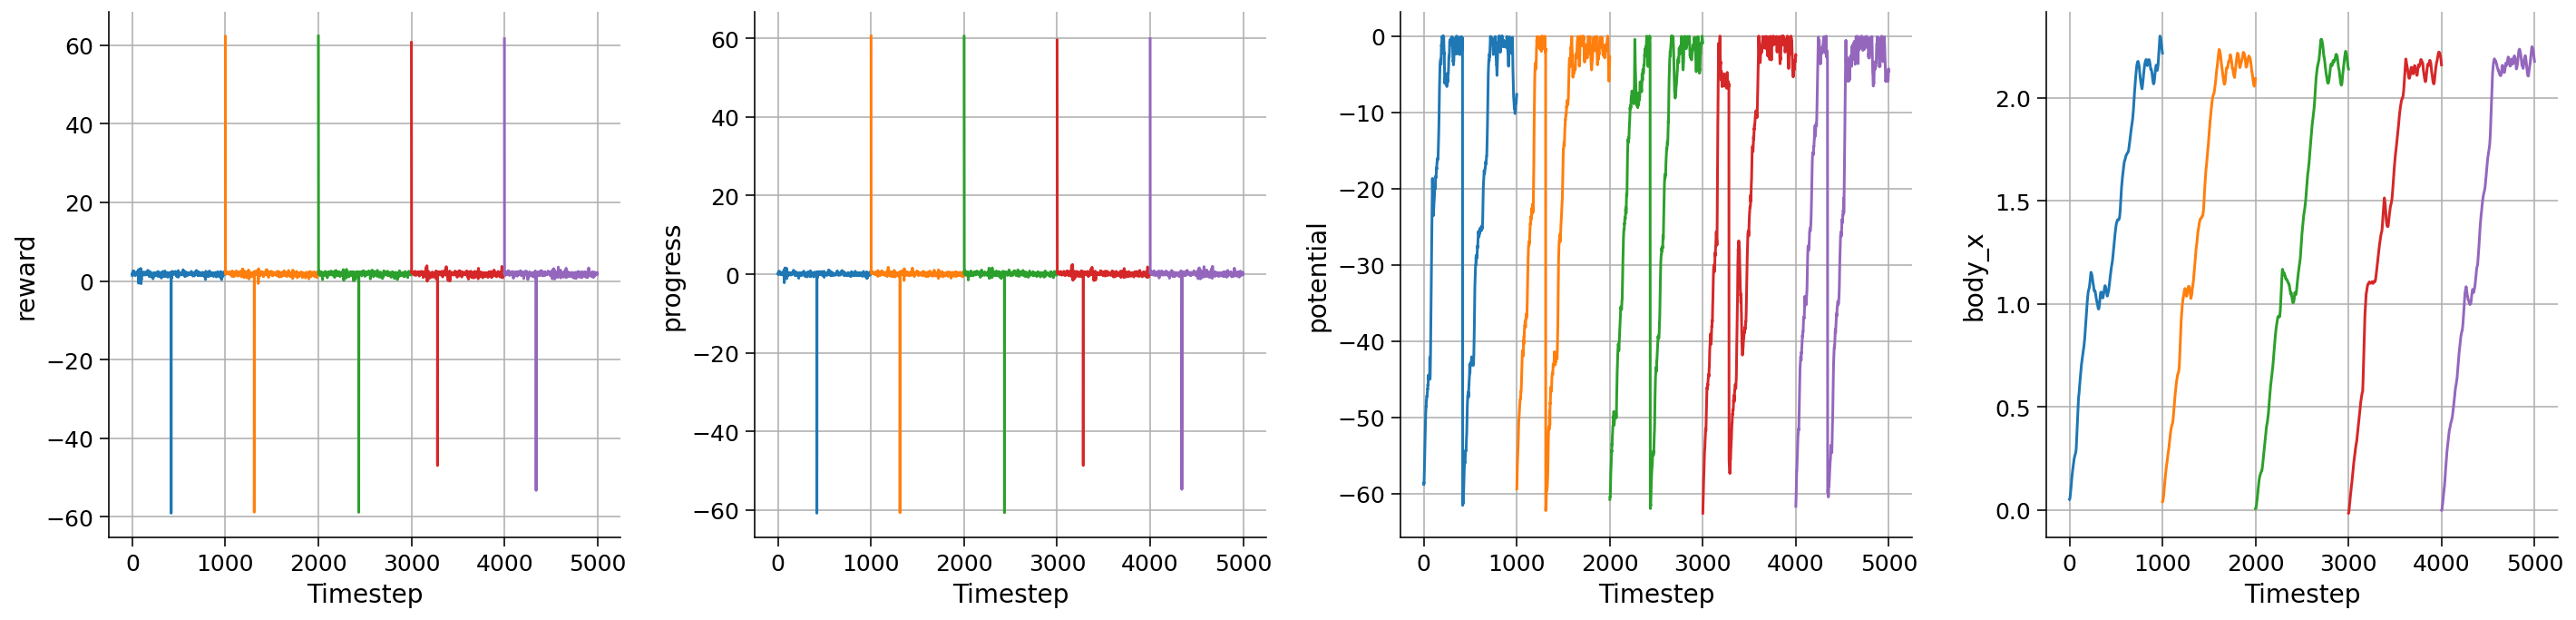

hopper_two_goal_training3
walk_target_x: 1
alive_coef: 2


In [179]:
var_analysis = {'reward': reward, 'progress':progress, 'potential':potential, 
                'body_x': body_x}

fig, axes = plt.subplots(1, len(var_analysis), figsize=[20,5])

i = 0
for key, value in var_analysis.items():
  env_step = 0
  ax = axes[i]
  i += 1

  for episode in value:    
    ax.plot(np.arange(env_step, env_step+len(episode)), episode)
    env_step += len(episode)
    ax.set_xlabel('Timestep', fontsize=14)
    ax.set_ylabel(key, fontsize=14)
    ax.grid(True)


b_plot_avg_body_x = False
if b_plot_avg_body_x:
  # last plot 
  # plot overshoot 
  # These parameters (overshoot and range width) are used to detect the hopper having reached and been standing still  
  mean_overshoot   = 0.05
  half_width_range = 0.05
  y0 = env.robot.walk_target_x+mean_overshoot
  ax.axhline(y0)
  ax.axhline(y0+half_width_range,linestyle='--')
  ax.axhline(y0-half_width_range,linestyle='--')


# ax.set_xlim((0, 1000)) # Visualize one episode 
plt.show()

print(load_agent_name)
print('walk_target_x:', env.robot.walk_target_x)
print('alive_coef:', alive_coef)

if b_plot_avg_body_x:
  print('overshoot:', mean_overshoot)
  print('half width window:', half_width_range)

# Seems initial body_x is somewhat random from episode to episode

In [73]:
env.step_counter_at_target_update
env.robot.walk_target_x

1000.0

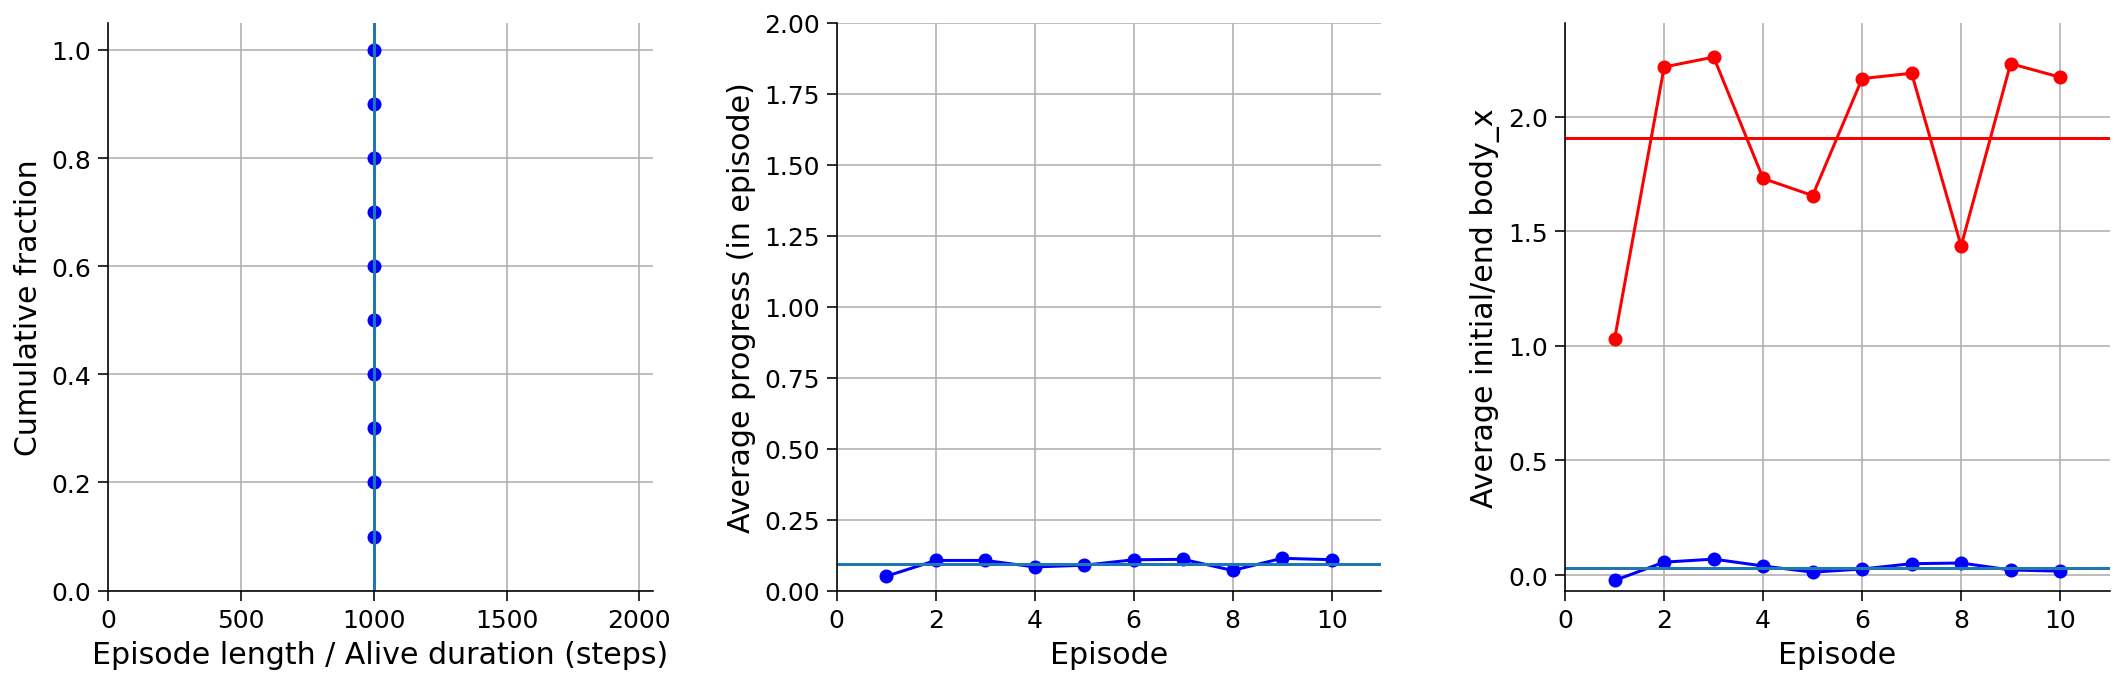

hopper_two_goal_training3
walk_target_x: 1
alive_coef: 2
Average episode length:  1000.0
Grand average progress: 0.095
Grand average initial body_x : 0.032
Grand average end body_x: 1.908


In [132]:
from scipy import stats

# Distribution of episode length (steps)
episode_length = []
for episode in reward:    
  episode_length.append(len(episode))

episode_length = np.array(episode_length)
avg_episode_length = np.mean(episode_length)

# Average progress (speed)
avg_progress = np.zeros(len(progress))
for i, p in enumerate(progress):
  p_np = np.array(p)
  avg_progress[i] = stats.trim_mean(p_np, 0.1)

grand_avg_progress = np.mean(avg_progress)

# Average body_x when the hopper reaches the distination
# it overshoots a bit
num_steps4mean = 10
avg_body_x_ini = np.zeros(len(body_x))
avg_body_x_end = np.zeros(len(body_x))
for i, bx in enumerate(body_x):
  avg_body_x_ini[i] = sum(bx[0:num_steps4mean])/num_steps4mean
  avg_body_x_end[i] = sum(bx[-num_steps4mean:])/num_steps4mean

grand_avg_body_x_ini = np.mean(avg_body_x_ini)
grand_avg_body_x_end = np.mean(avg_body_x_end)


#---------------
fig, axs = plt.subplots(1, 3, figsize=[3*5, 5])

# Cumulative distribution of episode length
plt.sca(axs[0])
y = np.arange(num_episodes_test)+1
y = y/len(episode_length)
x = np.sort(episode_length)

plt.plot(x, y,'bo-')
plt.grid()
plt.xlabel('Episode length / Alive duration (steps)')
plt.ylabel('Cumulative fraction')
plt.xlim((0, max_steps_in_episode +50))
plt.ylim((0, 1.05))

plt.axvline(avg_episode_length)

# Average velocity (progress)
plt.sca(axs[1])
x = np.arange(len(progress))+1
y = avg_progress

plt.plot(x, y,'bo-')
plt.axhline(grand_avg_progress)
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Average progress (in episode)')

plt.xlim((0, len(progress)+1))
plt.ylim((0, 2))

# Initial/End body_x
plt.sca(axs[2])
x = np.arange(len(progress))+1
y = avg_body_x_ini
plt.plot(x, y,'bo-')
plt.axhline(grand_avg_body_x_ini)

y = avg_body_x_end
plt.plot(x, y,'ro-')
plt.axhline(grand_avg_body_x_end, color='r')


plt.grid()
plt.xlabel('Episode')
plt.ylabel('Average initial/end body_x')

plt.xlim((0, len(progress)+1))
plt.ylim((grand_avg_body_x_ini-0.1, grand_avg_body_x_end+0.5))



plt.show()

print(load_agent_name)
print('walk_target_x:', env.robot.walk_target_x)
print('alive_coef:', alive_coef)
print('Average episode length: ', avg_episode_length)
print(f'Grand average progress: {grand_avg_progress:0.3f}')
print(f'Grand average initial body_x : {grand_avg_body_x_ini:0.3f}')
print(f'Grand average end body_x: {grand_avg_body_x_end:0.3f}')

# Good threshold would be >80% of the episodes, stay alive for 1000 steps (for both walking/standing)
# Avg progress > 1.0  

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [ ]:
# env.robot.walk_target_dist

5.869092225804058

In [ ]:
# travel_dist = env.potential/-100
# print('current distance:', travel_dist)

# 2021-08-13, 23:15: hopper_walker2, can walk like 600m 

current distance: 604.8495835386803


## Total reward

Finally, let's print the total reward for the test episodes

In [ ]:
for i, episode in enumerate(reward):
  print(f"Total reward in episode {i}: {sum(episode):.2f}")

Total reward in episode 0: 820.58


## Saving and restoring training checkpoints to/from Google Drive

To avoid losing the training checkpoints during runtime restart, follow these steps:

### 1. Mount drive to temporarily save checkpoints

In [25]:

# Mount drive. -- You may want to add your gDrive
drive.mount('/root/drive')

Mounted at /root/drive


### 2. BEFORE restarting the runtime, save checkpoint to drive

In [33]:
# Save agent checkpoint to drive.
assert save_agent_name is not 'hopper_walker2',     'do not override hopper_walker2'
assert save_agent_name is not 'hopper_walker3',     'do not override hopper_walker3'
assert save_agent_name is not 'hopper_backwalker1', 'do not override hopper_backwalker1'
assert save_agent_name is not 'hopper_backwalker1', 'do not override hopper_two_goal_training1'
assert save_agent_name is not 'hopper_backwalker1', 'do not override hopper_zerodistance'
assert save_agent_name is not 'hopper_two_goal_training2', 'do not override hopper_two_goal_training2'
assert save_agent_name is not 'hopper_walker4',     'do not override hopper_walker4'
assert save_agent_name is not 'hopper_two_goal_training3', 'do not override hopper_two_goal_training3'

print(save_agent_name)
input('Enter to proceed')

save_ckpt_to_drive(agent, save_agent_name)

hopper_two_goal_training3
Enter to proceed
Saved /root/acme/9c6eae66-ff11-11eb-9917-0242ac1c0002/checkpoints/d4pg_learner to /root/drive/MyDrive/acme_ckpt/hopper_two_goal_training3


### 3. AFTER restarting the runtime, restore checkpoint from drive

To restore a checkpoint in the restarted Colab runtime:

1.   Re-install all the libraries and run all the cells as before, including the agent instantiation, **except** the training cell. 
2.   Run the cell below.
3.   Run the cell that instantiates the agent **again**.

In [63]:
# Restore checkpoint from drive.
restore_ckpt_from_drive(agent, load_agent_name)

Restored /root/acme/416a98ca-0030-11ec-9e34-0242ac1c0002/checkpoints/d4pg_learner from /root/drive/MyDrive/acme_ckpt/hopper_two_goal_training3


In [64]:
# This is a copoied cell for convenience (to be used in conjunction with restore)

# checkpoint = False  # start fresh 
checkpoint = True
if b_agent_D4PG:
  # Create networks.
  policy_network, critic_network = make_networks_d4pg(action_spec)

  # Create agent.
  agent = D4PG(environment_spec=env_spec,
               policy_network=policy_network,
               critic_network=critic_network,
               observation_network=tf2_utils.batch_concat, # Identity Op.
               policy_optimizer=policy_optimizer,
               critic_optimizer=critic_optimizer,
               logger=learner_logger,
               checkpoint=checkpoint)

### 4. Optionally, unmount drive

In [ ]:
# Unmount drive.
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [106]:
# delete agent 
print(agent)
del agent
agent

NameError: ignored

---
# Examples of two additional agents:

## DMPO agent

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_dmpo(action_spec)

# Create agent.
agent = DistributionalMPO(environment_spec=env_spec,
                          policy_network=policy_network,
                          critic_network=critic_network,
                          observation_network=tf2_utils.batch_concat,
                          policy_optimizer=policy_optimizer,
                          critic_optimizer=critic_optimizer,
                          logger=learner_logger,
                          checkpoint=checkpoint)

## DDPG agent

In [ ]:
# Create networks.
policy_network, critic_network = make_networks_ddpg(action_spec)

# Create agent.
agent = DDPG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network= tf2_utils.batch_concat, # Identity Op.
             logger=learner_logger,
             checkpoint=checkpoint)

---
# Good luck :)

In [128]:
# keep the session alive 
aaa  = True
i = 1
while aaa:
  time.sleep(100)
  i += 1
  if i%10 == 1:
    print(i)


11
21


KeyboardInterrupt: ignored